In [ ]:
from pathlib import Path
import json
import itertools
import sys, os
import datetime as dt
import pandas as pd
import statsmodels.api as sm
from sklearn import linear_model
from sklearn.metrics import mean_squared_error
import numpy as np
from matplotlib import pyplot as plt
import seaborn as sns

In [ ]:
PROJPATH = Path().resolve().parent
sys.path.append((PROJPATH / 'scripts').as_posix())
import riverice_util as ru

In [ ]:
username = os.environ['USER']

In [ ]:
prefix = "DD25"       # set to TDD for Thawing Degree Days

tdd_anomalycorr = f"/Users/{username}/Projects/2023_Riverice/data/breakupdata/derived/{prefix}_anomaly_correlations.csv"
breakup_stats = f"/Users/{username}/Projects/2023_Riverice/data/breakupdata/derived/breakupdate_mean_std_1983_2022.csv"
breakupdata = Path(f'/Users/{username}/Projects/2023_Riverice/data/breakupdata/')
stationfolder = Path(f"/Users/{username}/Projects/2023_Riverice/data/weatherstations/ACIS/{prefix}/dd_cumul_bystation")
outfolder = Path(f"/Users/{username}/Projects/2023_Riverice/data/working")

Rename station names

In [ ]:
anomalycorrDF = pd.read_csv(tdd_anomalycorr, header=3, index_col=0)
anomalycorrDF

,date,stationname,location,r2,r,p,DateStamp
0,04-01,ALYESKA,Koyukuk River at Bettles,0.006324,0.079526,0.635067,2000-04-01
1,04-01,ANCHORAGE_MERRILL_FIELD,Koyukuk River at Bettles,0.000352,-0.018763,0.929067,2000-04-01
2,04-01,ANCHORAGE_TED_STEVENS_INTL_AP,Koyukuk River at Bettles,0.004262,0.065284,0.685092,2000-04-01
3,04-01,AUKE_BAY,Koyukuk River at Bettles,0.005658,0.075220,0.644580,2000-04-01
4,04-01,BARROW_AP,Koyukuk River at Bettles,0.009983,0.099915,0.534245,2000-04-01
...,...,...,...,...,...,...,...
98600,06-04,SITKA_AP,Gakona River at Gakona,0.115278,-0.339527,0.049471,2000-06-04
98601,06-04,SKAGWAY_AP,Gakona River at Gakona,0.065209,-0.255361,0.208012,2000-06-04
98602,06-04,TALKEETNA_AP,Gakona River at Gakona,0.324413,-0.569573,0.000438,2000-06-04
98603,06-04,TANANA_AP,Gakona River at Gakona,0.093829,-0.306316,0.082962,2000-06-04


### Prototyping: Eagle

In [ ]:
location = 'Yukon River at Eagle'

In [ ]:
eagleDF = anomalycorrDF[anomalycorrDF.location == location]
eagleDF['DateStamp'] = pd.to_datetime(eagleDF['DateStamp'], format='%Y-%m-%d')
eagleDF

/var/folders/jh/dmrl1jcn7ql6ftcyq7l6p8v80000gn/T/ipykernel_77263/121066999.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  eagleDF['DateStamp'] = pd.to_datetime(eagleDF['DateStamp'], format='%Y-%m-%d')


,date,stationname,location,r2,r,p,DateStamp
1147,04-01,ALYESKA,Yukon River at Eagle,0.039465,-0.198657,2.253684e-01,2000-04-01
1148,04-01,ANCHORAGE_MERRILL_FIELD,Yukon River at Eagle,0.076806,-0.277139,1.798554e-01,2000-04-01
1149,04-01,ANCHORAGE_TED_STEVENS_INTL_AP,Yukon River at Eagle,0.015018,-0.122547,4.337033e-01,2000-04-01
1150,04-01,AUKE_BAY,Yukon River at Eagle,0.019506,-0.139664,3.776966e-01,2000-04-01
1151,04-01,BARROW_AP,Yukon River at Eagle,0.007911,-0.088945,5.705863e-01,2000-04-01
...,...,...,...,...,...,...,...
98267,06-04,SITKA_AP,Yukon River at Eagle,0.301944,-0.549494,1.354453e-04,2000-06-04
98268,06-04,SKAGWAY_AP,Yukon River at Eagle,0.295278,-0.543395,1.082957e-03,2000-06-04
98269,06-04,TALKEETNA_AP,Yukon River at Eagle,0.438530,-0.662216,1.321208e-06,2000-06-04
98270,06-04,TANANA_AP,Yukon River at Eagle,0.587404,-0.766423,3.290229e-09,2000-06-04


In [ ]:
grouped = eagleDF.drop(
        columns=['date', 'location', 'r', 'p']).groupby(
                ['stationname', pd.Grouper(key='DateStamp', freq='15D')]).mean().reset_index()

In [ ]:
max4 = (
    grouped
        .groupby(['DateStamp'])
        .apply(lambda group: group.nlargest(4, columns='r2'))
).reset_index(drop=True)

In [ ]:
max4

,stationname,DateStamp,r2
0,FAIRBANKS_INTL_AP,2000-04-01,0.173141
1,CHICKEN,2000-04-01,0.165085
2,NORTH_POLE,2000-04-01,0.146887
3,EAGLE,2000-04-01,0.142157
4,FAIRBANKS_INTL_AP,2000-04-16,0.501173
5,EAGLE,2000-04-16,0.453375
6,COLLEGE_OBSERVATORY,2000-04-16,0.445269
7,NORTH_POLE,2000-04-16,0.426533
8,EAGLE,2000-05-01,0.713936
9,CHICKEN,2000-05-01,0.709994


In [ ]:
datestamps = ['2000-04-01', '2000-04-16',
       '2000-05-01', '2000-05-16']

In [ ]:
sites = set()
maxN = 10
for datestamp in datestamps:
    for station in max4[max4.DateStamp== datestamp].stationname.to_list():
        if station == 'COLLEGE_OBSERVATORY':
            continue
        if station not in sites:
            break
    print(station)
    sites.add(station)
    if len(sites) == maxN:
        break 

FAIRBANKS_INTL_AP
EAGLE
CHICKEN
TANANA_AP


In [ ]:
sites

{'CHICKEN', 'EAGLE', 'FAIRBANKS_INTL_AP', 'TANANA_AP'}

In [ ]:
def restore_stationnames(stationlst):
    return [
        item.replace('AP', 'AIRPORT')           # .replace('INTL', 'INTERNATIONAL')
        for item in stationlst
        ]

sites1 = list(sites)
# sites1 = restore_stationnames(sites1)
sites2 = ['FAIRBANKS_INTL_AP', 'EAGLE', 'BIG_DELTA_AP', 'NENANA_MUN_AP']
# sites2 = restore_stationnames(sites2)
sites1, sites2

(['FAIRBANKS_INTL_AP', 'TANANA_AP', 'CHICKEN', 'EAGLE'],
 ['FAIRBANKS_INTL_AP', 'EAGLE', 'BIG_DELTA_AP', 'NENANA_MUN_AP'])

In [ ]:
stationsdfs = {}
stationfolder = Path(f"/Users/{username}/Projects/2023_Riverice/data/weatherstations/ACIS/{prefix}/dd_cumul_bystation")
for station in sites1:
    stationsdfs[station] = pd.read_csv(stationfolder / f"{station}_yearly_{prefix}_cumul.csv", skiprows=4, index_col=0)

In [ ]:
stationsdfs.keys()

dict_keys(['FAIRBANKS_INTL_AP', 'TANANA_AP', 'CHICKEN', 'EAGLE'])

In [ ]:
# sites2 = ['FAIRBANKS_INTL_AP', 'EAGLE', 'BIG_DELTAa_AP', 'NENANA_MUN_AP']
# stationsdfs = {}
# stationfolder = Path("/Users/christine/Projects/2023_Riverice/data/weatherstations/ACIS/TDD/tdd_cumul_bystation")
# for station in sites2:
#     stationsdfs[station] = pd.read_csv(stationfolder / f"{station}_yearly_TDD_cumul.csv", skiprows=4, index_col=0)

In [ ]:
stationsdfs['FAIRBANKS_INTL_AP']

,1980,1981,1982,1983,1984,1985,1986,1987,1988,1989,...,2013,2014,2015,2016,2017,2018,2019,2020,2021,2022
d_since_march1,,,,,,,,,,,,,,,,,,,,,
0,0.0,5.5,0.0,0.0,0.0,0.0,0.0,0.0,3.5,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,5.5,0.0,0.0,0.0,0.0,0.0,0.0,8.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,5.5,0.0,0.0,0.0,0.0,0.0,0.0,9.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,5.5,0.0,0.0,0.0,0.0,0.0,0.0,9.0,0.0,...,0.0,0.0,3.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,5.5,0.0,0.0,0.0,0.0,0.0,0.0,9.0,0.0,...,0.0,0.0,6.5,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
117,1966.0,2059.0,1707.0,2124.5,1907.0,1627.5,1850.0,2134.0,2224.5,1960.5,...,1703.0,2016.5,2259.0,2371.0,2072.0,1863.5,2409.0,2055.5,2108.5,1915.5
118,2004.0,2084.5,1752.0,2169.5,1943.5,1663.0,1892.0,2171.0,2260.5,1995.0,...,1752.5,2045.5,2290.0,2405.5,2113.5,1902.5,2449.0,2090.5,2146.5,1957.0
119,2036.0,2110.5,1797.0,2211.5,1982.5,1699.5,1938.0,2210.0,2300.0,2031.0,...,1800.0,2080.0,2324.5,2444.0,2155.0,1939.0,2495.5,2125.0,2183.0,1997.0


In [ ]:
mean_eagle = pd.concat(stationsdfs.values())
mean_eagle = mean_eagle.groupby(mean_eagle.index).mean()
mean_eagle

,1980,1981,1982,1983,1984,1985,1986,1987,1988,1989,...,2013,2014,2015,2016,2017,2018,2019,2020,2021,2022
d_since_march1,,,,,,,,,,,,,,,,,,,,,
0,0.000000,1.833333,0.00,0.000000,0.000000,0.000000,0.000000,0.000000,1.166667,0.000000,...,0.000,0.000,0.000,0.0000,0.0000,0.000,0.000,0.000,0.000,0.000000
1,0.000000,2.166667,0.00,0.000000,0.000000,0.000000,0.000000,0.000000,3.333333,0.000000,...,0.000,0.000,0.000,0.0000,0.0000,0.000,0.000,0.000,0.000,0.000000
2,0.000000,2.166667,0.00,0.000000,0.000000,0.000000,0.000000,0.000000,6.500000,0.000000,...,0.000,0.000,0.000,0.0000,0.0000,0.000,0.000,0.000,0.000,0.000000
3,0.000000,2.166667,0.00,0.000000,0.000000,0.000000,0.000000,0.000000,6.500000,0.000000,...,0.000,0.000,1.000,0.0000,0.0000,0.000,0.000,0.000,0.000,0.000000
4,0.000000,2.166667,0.00,0.000000,2.000000,0.000000,0.000000,0.000000,6.500000,0.000000,...,0.000,0.000,2.000,0.0000,0.0000,0.000,0.000,0.000,0.000,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
117,1821.166667,1896.666667,1574.00,1829.500000,1737.580000,1483.000000,1616.546667,1837.636667,2007.500000,1815.170000,...,1462.500,1726.625,1947.750,2010.2575,1771.2500,1620.585,2054.120,1811.275,1780.560,1650.303333
118,1858.833333,1926.000000,1618.00,1873.833333,1775.080000,1516.500000,1651.880000,1871.303333,2045.666667,1849.836667,...,1506.000,1753.125,1981.625,2046.8825,1806.7500,1655.210,2090.245,1840.275,1815.435,1688.136667
119,1895.333333,1950.166667,1662.00,1916.000000,1811.580000,1549.833333,1691.643333,1907.303333,2081.166667,1886.170000,...,1552.375,1785.250,2011.500,2082.7575,1843.5600,1687.335,2131.370,1871.150,1849.560,1726.136667


In [ ]:
outpath = Path(f"/Users/{username}/Projects/2023_Riverice/data/weatherstations/ACIS_combined_DD")
whichsites = ', '.join(sites)
with open(outpath / f"{prefix}_combined_{location.replace(' ', '_')}.csv", 'w') as dst:
        dst.write(f"# Cumulative {prefix} averaged for {location}\n")
        dst.write(f"# Sites: {whichsites}\n")
        dst.write("#\n")
        mean_eagle.to_csv(dst, float_format='%.2f')

### All locations

In [ ]:
locations = list(set(anomalycorrDF.location.to_list()))
datestamps = ['2000-04-01', '2000-04-16',
       '2000-05-01', '2000-05-16']
maxN = 10
stationfolder = Path(f"/Users/christine/Projects/2023_Riverice/data/weatherstations/ACIS/{prefix}/dd_cumul_bystation")
outpath = Path("/Users/christine/Projects/2023_Riverice/data/weatherstations/ACIS_combined_DD")


for location in locations:
    print(f"Working on {location}")
    locDF = anomalycorrDF[anomalycorrDF.location == location]
    locDF['DateStamp'] = pd.to_datetime(locDF['DateStamp'], format='%Y-%m-%d')
    grouped = locDF.drop(
        columns=['date', 'location', 'r', 'p']).groupby(
                ['stationname', pd.Grouper(key='DateStamp', freq='15D')]).mean().reset_index()
    max4 = (grouped
                .groupby(['DateStamp'])
                .apply(lambda group: group.nlargest(4, columns='r2'))
        ).reset_index(drop=True)
    sites = set()
    for datestamp in datestamps:
        for station in max4[max4.DateStamp== datestamp].stationname.to_list():
            if station == 'COLLEGE_OBSERVATORY':
                continue
            if station not in sites:
                break
        sites.add(station)
        if len(sites) == maxN:
            break 
    sites = list(sites)
    stationsdfs = {}
    for station in sites:
        try: 
            stationsdfs[station] = pd.read_csv(stationfolder / f"{station}_yearly_{prefix}_cumul.csv", skiprows=4, index_col=0)
        except FileNotFoundError:
            stationsdfs[station] = pd.read_csv(stationfolder / f"{station.replace('AP', 'AIRPORT')}_yearly_{prefix}_cumul.csv", skiprows=4, index_col=0)
    mean_loc = pd.concat(stationsdfs.values())
    mean_loc = mean_loc.groupby(mean_loc.index).mean()
    whichsites = ', '.join(sites)
    with open(outpath / f"{prefix}_combined_{location.replace(' ', '_')}.csv", 'w') as dst:
            dst.write(f"# Cumulative {prefix} averaged for {location}\n")
            dst.write(f"# Sites: {whichsites}\n")
            dst.write("#\n")
            mean_loc.to_csv(dst, float_format='%.2f')


Working on Kuskokwim River at Nikolai
Working on Yukon River at Anvik
Working on Yukon River at Eagle
Working on Yukon River at Galena
Working on Kobuk River at Ambler


/var/folders/39/6h0p929579n8vrp25cjkbz3h0000gn/T/ipykernel_5100/1635248383.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  locDF['DateStamp'] = pd.to_datetime(locDF['DateStamp'], format='%Y-%m-%d')
/var/folders/39/6h0p929579n8vrp25cjkbz3h0000gn/T/ipykernel_5100/1635248383.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  locDF['DateStamp'] = pd.to_datetime(locDF['DateStamp'], format='%Y-%m-%d')
/var/folders/39/6h0p929579n8vrp25cjkbz3h0000gn/T/ipykernel_5100/1635248383.py:12: SettingWithCopyWarning: 

Working on Yukon River at Ruby
Working on Gakona River at Gakona
Working on Yukon River at Circle
Working on Yukon River at Marshall
Working on Kuskokwim River at Crooked Creek


/var/folders/39/6h0p929579n8vrp25cjkbz3h0000gn/T/ipykernel_5100/1635248383.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  locDF['DateStamp'] = pd.to_datetime(locDF['DateStamp'], format='%Y-%m-%d')
/var/folders/39/6h0p929579n8vrp25cjkbz3h0000gn/T/ipykernel_5100/1635248383.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  locDF['DateStamp'] = pd.to_datetime(locDF['DateStamp'], format='%Y-%m-%d')
/var/folders/39/6h0p929579n8vrp25cjkbz3h0000gn/T/ipykernel_5100/1635248383.py:12: SettingWithCopyWarning: 

Working on Koyukuk River at Allakaket
Working on Kobuk River at Shungnak
Working on Yukon River at Alakanuk
Working on Kuskokwim River at McGrath
Working on Gulkana River nr Gakona


/var/folders/39/6h0p929579n8vrp25cjkbz3h0000gn/T/ipykernel_5100/1635248383.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  locDF['DateStamp'] = pd.to_datetime(locDF['DateStamp'], format='%Y-%m-%d')
/var/folders/39/6h0p929579n8vrp25cjkbz3h0000gn/T/ipykernel_5100/1635248383.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  locDF['DateStamp'] = pd.to_datetime(locDF['DateStamp'], format='%Y-%m-%d')
/var/folders/39/6h0p929579n8vrp25cjkbz3h0000gn/T/ipykernel_5100/1635248383.py:12: SettingWithCopyWarning: 

Working on Tanana River at Nenana
Working on Chisana River at Northway
Working on Kuskokwim River at Red Devil
Working on Yukon River at Kaltag
Working on Chena River at Fairbanks


/var/folders/39/6h0p929579n8vrp25cjkbz3h0000gn/T/ipykernel_5100/1635248383.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  locDF['DateStamp'] = pd.to_datetime(locDF['DateStamp'], format='%Y-%m-%d')
/var/folders/39/6h0p929579n8vrp25cjkbz3h0000gn/T/ipykernel_5100/1635248383.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  locDF['DateStamp'] = pd.to_datetime(locDF['DateStamp'], format='%Y-%m-%d')
/var/folders/39/6h0p929579n8vrp25cjkbz3h0000gn/T/ipykernel_5100/1635248383.py:12: SettingWithCopyWarning: 

Working on Yukon River at Tanana
Working on Yukon River at Russian Mission
Working on Tanana River nr Manley Hot Springs
Working on Kuskokwim River at Stony River
Working on Yukon River at Dawson


/var/folders/39/6h0p929579n8vrp25cjkbz3h0000gn/T/ipykernel_5100/1635248383.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  locDF['DateStamp'] = pd.to_datetime(locDF['DateStamp'], format='%Y-%m-%d')
/var/folders/39/6h0p929579n8vrp25cjkbz3h0000gn/T/ipykernel_5100/1635248383.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  locDF['DateStamp'] = pd.to_datetime(locDF['DateStamp'], format='%Y-%m-%d')
/var/folders/39/6h0p929579n8vrp25cjkbz3h0000gn/T/ipykernel_5100/1635248383.py:12: SettingWithCopyWarning: 

Working on Yukon River at Mountain Village
Working on Yukon River at Fort Yukon
Working on Kuskokwim River at Akiak
Working on Koyukuk River at Hughes
Working on Kuskokwim River at Tuluksak


/var/folders/39/6h0p929579n8vrp25cjkbz3h0000gn/T/ipykernel_5100/1635248383.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  locDF['DateStamp'] = pd.to_datetime(locDF['DateStamp'], format='%Y-%m-%d')
/var/folders/39/6h0p929579n8vrp25cjkbz3h0000gn/T/ipykernel_5100/1635248383.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  locDF['DateStamp'] = pd.to_datetime(locDF['DateStamp'], format='%Y-%m-%d')
/var/folders/39/6h0p929579n8vrp25cjkbz3h0000gn/T/ipykernel_5100/1635248383.py:12: SettingWithCopyWarning: 

Working on Kuskokwim River at Aniak
Working on Yukon River nr Emmonak
Working on Kobuk River at Kobuk
Working on Koyukuk River at Bettles
Working on Susitna River at Sunshine


/var/folders/39/6h0p929579n8vrp25cjkbz3h0000gn/T/ipykernel_5100/1635248383.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  locDF['DateStamp'] = pd.to_datetime(locDF['DateStamp'], format='%Y-%m-%d')
/var/folders/39/6h0p929579n8vrp25cjkbz3h0000gn/T/ipykernel_5100/1635248383.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  locDF['DateStamp'] = pd.to_datetime(locDF['DateStamp'], format='%Y-%m-%d')
/var/folders/39/6h0p929579n8vrp25cjkbz3h0000gn/T/ipykernel_5100/1635248383.py:12: SettingWithCopyWarning: 

Working on Kuskokwim River at Bethel
Working on Kuskokwim River at Kalskag
Working on Buckland River at Buckland
Working on Kuskokwim River at Sleetmute
Working on Yentna River at Lake Creek
Working on Yukon River at Holy Cross


/var/folders/39/6h0p929579n8vrp25cjkbz3h0000gn/T/ipykernel_5100/1635248383.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  locDF['DateStamp'] = pd.to_datetime(locDF['DateStamp'], format='%Y-%m-%d')
/var/folders/39/6h0p929579n8vrp25cjkbz3h0000gn/T/ipykernel_5100/1635248383.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  locDF['DateStamp'] = pd.to_datetime(locDF['DateStamp'], format='%Y-%m-%d')
/var/folders/39/6h0p929579n8vrp25cjkbz3h0000gn/T/ipykernel_5100/1635248383.py:12: SettingWithCopyWarning: 

In [ ]:
restore_stationnames("BigDelta_AP")

['B', 'i', 'g', 'D', 'e', 'l', 't', 'a', '_', 'A', 'P']

## Likelihoods for Eagle

In [ ]:
location = "Yukon River at Eagle"

In [ ]:
def datestr2dayssince(datestr, since='0301'):
    thedate = dt.datetime.strptime(datestr, '%Y-%m-%d').date()
    since_mth = int(since[:2])
    since_day = int(since[3:])
    since_date = dt.date(thedate.year, since_mth, since_day)
    return (thedate - since_date).days
def dayssince2date(days, year=2000, since='0301'):
    since_date = dt.datetime.strptime(f"{year}{since}", "%Y%m%d").date()
    return (since_date + dt.timedelta(days=days)).strftime("%m-%d")

In [ ]:
breakuppth = breakupdata / "derived/breakupDate_cleaned.csv"
breakup = pd.read_csv(breakuppth, header=3, index_col=0)
breakup = breakup[breakup.siteID == location].sort_values(by='year').reset_index(drop=True)
breakup['days_since_march1'] = breakup.apply(lambda row: datestr2dayssince(row.breakup), axis=1)
breakup

,id,siteID,year,breakup,days_since_march1
0,5330,Yukon River at Eagle,1980,1980-05-03,63
1,5331,Yukon River at Eagle,1981,1981-05-07,67
2,5332,Yukon River at Eagle,1982,1982-05-14,74
3,5333,Yukon River at Eagle,1983,1983-05-02,62
4,5334,Yukon River at Eagle,1984,1984-05-09,69
5,5335,Yukon River at Eagle,1985,1985-05-16,76
6,5336,Yukon River at Eagle,1986,1986-05-11,71
7,5337,Yukon River at Eagle,1987,1987-05-09,69
8,5338,Yukon River at Eagle,1988,1988-05-02,62
9,5339,Yukon River at Eagle,1989,1989-04-29,59


In [ ]:
breakup.dtypes

id                    int64
siteID               object
year                  int64
breakup              object
days_since_march1     int64
dtype: object

In [ ]:
breakup_avg_model = linear_model.LinearRegression() 
breakup_avg_model.fit(breakup[['year']], breakup[['days_since_march1']])

LinearRegression()

In [ ]:
mu_0 = breakup_avg_model.predict([[2023]]).item()

start = 0 
xs = np.arange(0, 101)

In [ ]:
sigma_0 = mean_squared_error([breakup_avg_model.predict([[yr]]).item() for yr in breakup['year'].tolist()],
                   breakup['days_since_march1'].tolist(), squared=False)

/Users/chris/mambaforge/envs/fiweps/lib/python3.10/site-packages/sklearn/base.py:409: UserWarning: X does not have valid feature names, but LinearRegression was fitted with feature names
  warnings.warn(
/Users/chris/mambaforge/envs/fiweps/lib/python3.10/site-packages/sklearn/base.py:409: UserWarning: X does not have valid feature names, but LinearRegression was fitted with feature names
  warnings.warn(
/Users/chris/mambaforge/envs/fiweps/lib/python3.10/site-packages/sklearn/base.py:409: UserWarning: X does not have valid feature names, but LinearRegression was fitted with feature names
  warnings.warn(
/Users/chris/mambaforge/envs/fiweps/lib/python3.10/site-packages/sklearn/base.py:409: UserWarning: X does not have valid feature names, but LinearRegression was fitted with feature names
  warnings.warn(
/Users/chris/mambaforge/envs/fiweps/lib/python3.10/site-packages/sklearn/base.py:409: UserWarning: X does not have valid feature names, but LinearRegression was fitted with feature nam

In [ ]:
import scipy.stats as stats
import math

In [ ]:
sns.set_style('whitegrid')

(0.0, 70.0)

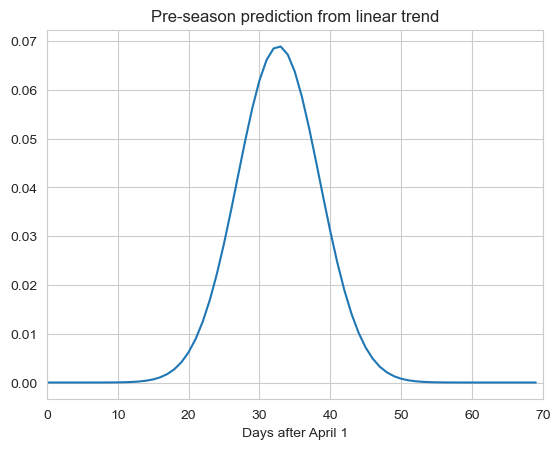

In [ ]:
plt.plot(xs-31, stats.norm.pdf(xs, mu_0, sigma_0))
plt.title("Pre-season prediction from linear trend")
plt.xlabel("Days after April 1")
plt.xlim((0,70))

In [ ]:
breakup[breakup['days_since_march1']==65].year.to_list()

[2020]

In [ ]:
possible_days = sorted(list(set(breakup['days_since_march1'])))
records = []

for days_after_march_1 in range(30, 80):
    days_from_now_possible = [item-days_after_march_1 for item in possible_days]
    if len(days_from_now_possible) != 0:
        for days in days_from_now_possible:
            days_possible = days + days_after_march_1
            years = breakup[breakup['days_since_march1']==days_possible].year.astype(str).to_list()
            if len(years) == 0: 
                print("This shouldnt happen")
                continue
            print(days_after_march_1, days_possible, mean_eagle[years].mean(axis=1)[days_after_march_1])
            records.append(
                {'forecast_day_past_march1': days_after_march_1,
                    'days_from_then': days,
                    'mean_DD': mean_eagle[years].mean(axis=1)[days_after_march_1]}
            )
likelihoodDF = pd.DataFrame.from_records(records)
likelihoodDF

30 55 54.166666666666664
30 56 51.875
30 57 6.875
30 58 12.5625
30 59 26.738095238095237
30 60 0.0
30 61 65.0
30 62 18.416666666666668
30 63 8.40625
30 64 0.625
30 65 24.0
30 66 20.9375
30 67 28.972222222222225
30 68 8.625
30 69 42.75
30 71 8.125
30 72 29.208333333333332
30 74 30.0
30 76 5.166666666666667
30 77 2.625
30 78 1.375
31 55 59.666666666666664
31 56 61.125
31 57 6.875
31 58 12.5625
31 59 31.434523809523814
31 60 0.5
31 61 69.625
31 62 18.5
31 63 13.5625
31 64 4.125
31 65 24.0
31 66 22.6875
31 67 29.472222222222225
31 68 9.28125
31 69 47.66666666666667
31 71 9.1875
31 72 29.208333333333332
31 74 30.0
31 76 5.166666666666667
31 77 4.625
31 78 1.375
32 55 62.666666666666664
32 56 66.75
32 57 6.875
32 58 12.5625
32 59 36.363095238095234
32 60 0.5
32 61 73.0625
32 62 19.0
32 63 19.614583333333336
32 64 8.5
32 65 24.375
32 66 24.0625
32 67 31.083333333333332
32 68 9.3125
32 69 50.416666666666664
32 71 9.25
32 72 30.208333333333332
32 74 30.0
32 76 5.166666666666667
32 77 4.625
32 7

,forecast_day_past_march1,days_from_then,mean_DD
0,30,25,54.166667
1,30,26,51.875000
2,30,27,6.875000
3,30,28,12.562500
4,30,29,26.738095
...,...,...,...
1045,79,-7,400.215833
1046,79,-5,474.750000
1047,79,-3,364.833333
1048,79,-2,197.875000


In [ ]:
possible_days = sorted(list(set(breakup['days_since_march1'])))
records = []

for days_after_march_1 in range(10, 80):
    days_from_now_possible = [item-days_after_march_1 for item in possible_days]
    if len(days_from_now_possible) != 0:
        for days in days_from_now_possible:
            days_possible = days + days_after_march_1
            years = breakup[breakup['days_since_march1']==days_possible].year.astype(str).to_list()
            if len(years) == 0: 
                print("This shouldnt happen")
                continue
            for year in years:
                # print(year, days_after_march_1, mean_eagle[year][days_after_march_1])
                records.append({
                    'forecast_day_past_march1': days_after_march_1,
                    'year': year,
                    'days_from_then': days,
                    'mean_DD': mean_eagle[year][days_after_march_1]}
                )
likelihoodDF = pd.DataFrame.from_records(records)
likelihoodDF['day_absolute_since_march_1'] = likelihoodDF['forecast_day_past_march1'] + likelihoodDF['days_from_then']
likelihoodDF['forecastdate'] = likelihoodDF['forecast_day_past_march1'].apply(dayssince2date)
likelihoodDF

,forecast_day_past_march1,year,days_from_then,mean_DD,day_absolute_since_march_1,forecastdate
0,10,1990,45,4.666667,55,03-11
1,10,2016,46,0.000000,56,03-11
2,10,2003,47,6.875000,57,03-11
3,10,1991,48,0.000000,58,03-11
4,10,2005,48,2.500000,58,03-11
...,...,...,...,...,...,...
3005,79,2001,-7,421.835000,72,05-19
3006,79,1982,-5,474.750000,74,05-19
3007,79,1985,-3,364.833333,76,05-19
3008,79,2013,-2,197.875000,77,05-19


In [ ]:
likelihoodDF[(likelihoodDF.forecast_day_past_march1==55) & (likelihoodDF['year']=='2022')]['mean_DD'].squeeze()

90.5

In [ ]:
mean_eagle['2000'][65]

241.8775

In [ ]:
ru.dayssince2date(30, 2022)

datetime.date(2022, 3, 31)

14.311356888853375 3.8695121844523652 12 0.00015145152460026344 0.01102944783196823 0.30820271191443677 0.591283288452984


/var/folders/jh/dmrl1jcn7ql6ftcyq7l6p8v80000gn/T/ipykernel_77263/3534468163.py:40: MatplotlibDeprecationWarning: The 'b' parameter of grid() has been renamed 'visible' since Matplotlib 3.5; support for the old name will be dropped two minor releases later.
  ax2.grid(b=None)


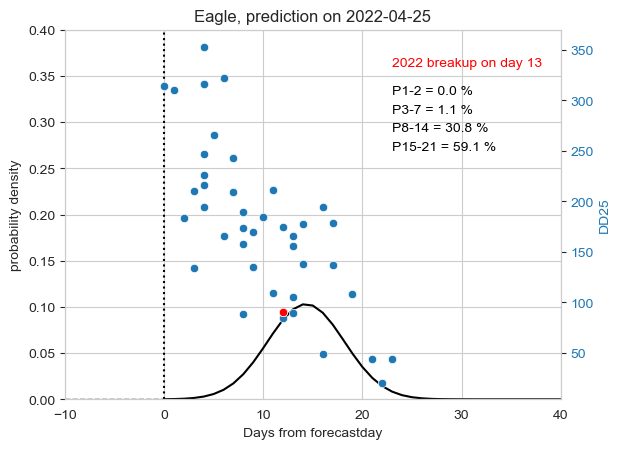

12.26389470288536 3.530720585219007 10 0.00036854580574386146 0.026882349728817763 0.49952636261672834 0.45344283466561336


/var/folders/jh/dmrl1jcn7ql6ftcyq7l6p8v80000gn/T/ipykernel_77263/3534468163.py:40: MatplotlibDeprecationWarning: The 'b' parameter of grid() has been renamed 'visible' since Matplotlib 3.5; support for the old name will be dropped two minor releases later.
  ax2.grid(b=None)


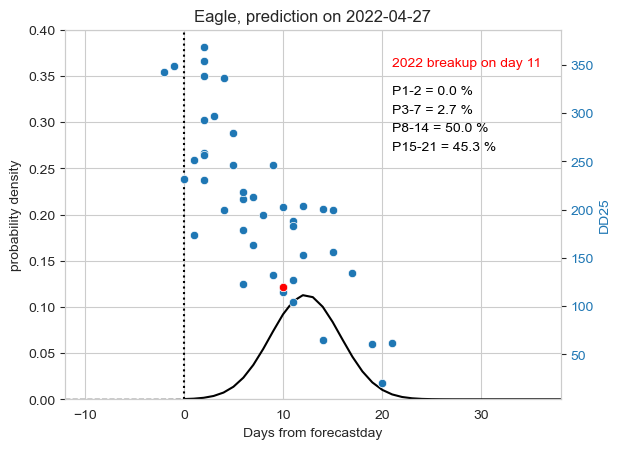

10.099863577502322 3.278452408272199 8 0.0014531435514567458 0.07788850153346166 0.6897340312762873 0.22931931505160424


/var/folders/jh/dmrl1jcn7ql6ftcyq7l6p8v80000gn/T/ipykernel_77263/3534468163.py:40: MatplotlibDeprecationWarning: The 'b' parameter of grid() has been renamed 'visible' since Matplotlib 3.5; support for the old name will be dropped two minor releases later.
  ax2.grid(b=None)


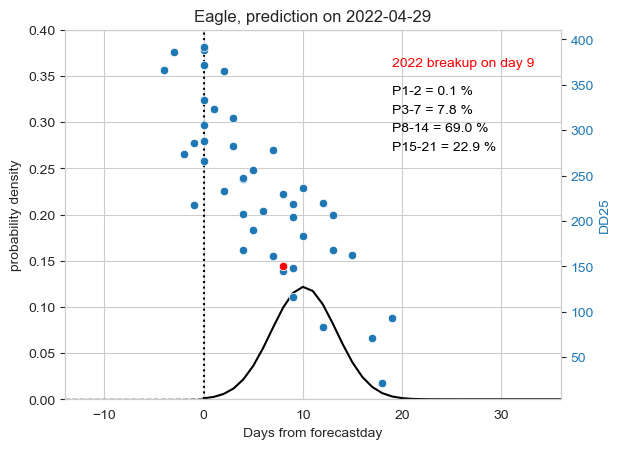

7.88549876814599 3.124166859594625 6 0.0075453971000029076 0.213540072184169 0.7119300765786993 0.06913459576247694


/var/folders/jh/dmrl1jcn7ql6ftcyq7l6p8v80000gn/T/ipykernel_77263/3534468163.py:40: MatplotlibDeprecationWarning: The 'b' parameter of grid() has been renamed 'visible' since Matplotlib 3.5; support for the old name will be dropped two minor releases later.
  ax2.grid(b=None)


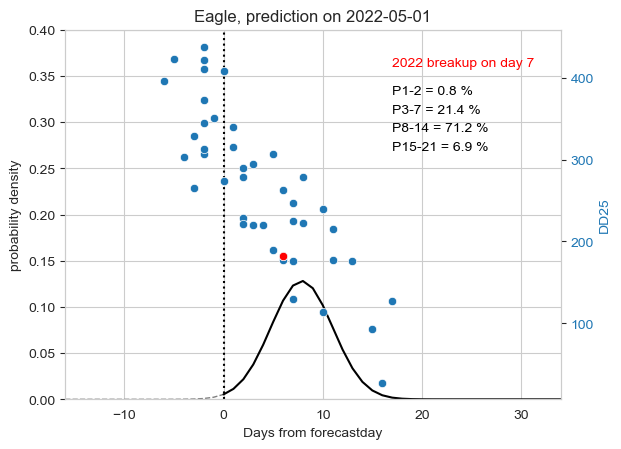

5.493693680136785 2.948765074107175 4 0.03657884972196182 0.46602723121738787 0.5009572370042582 0.008659918483663289


/var/folders/jh/dmrl1jcn7ql6ftcyq7l6p8v80000gn/T/ipykernel_77263/3534468163.py:40: MatplotlibDeprecationWarning: The 'b' parameter of grid() has been renamed 'visible' since Matplotlib 3.5; support for the old name will be dropped two minor releases later.
  ax2.grid(b=None)


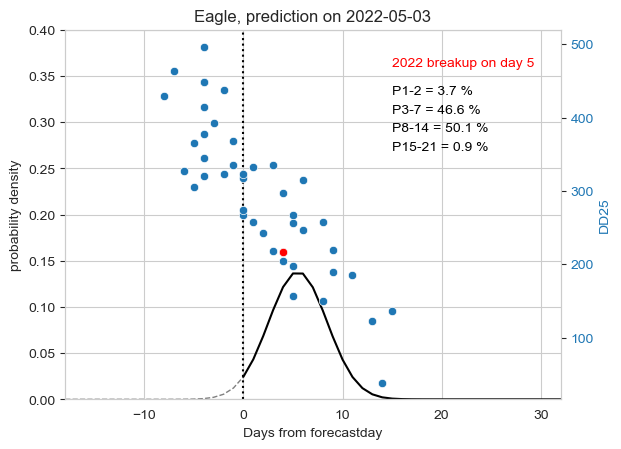

3.243493830091012 2.828345502862013 2 0.1308452458802856 0.6869488521173529 0.23204230467232978 0.0005518765733250596


/var/folders/jh/dmrl1jcn7ql6ftcyq7l6p8v80000gn/T/ipykernel_77263/3534468163.py:40: MatplotlibDeprecationWarning: The 'b' parameter of grid() has been renamed 'visible' since Matplotlib 3.5; support for the old name will be dropped two minor releases later.
  ax2.grid(b=None)


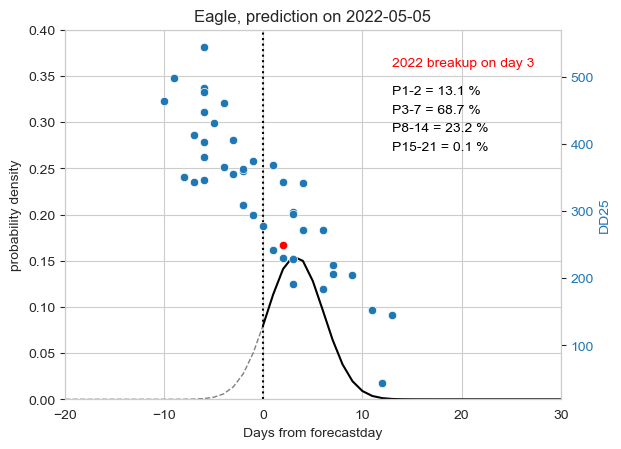

1.192693863879736 2.8359214811194713 0 0.3211808066251426 0.7352019630492805 0.08732777971064724 4.223962867897971e-05


/var/folders/jh/dmrl1jcn7ql6ftcyq7l6p8v80000gn/T/ipykernel_77263/3534468163.py:40: MatplotlibDeprecationWarning: The 'b' parameter of grid() has been renamed 'visible' since Matplotlib 3.5; support for the old name will be dropped two minor releases later.
  ax2.grid(b=None)


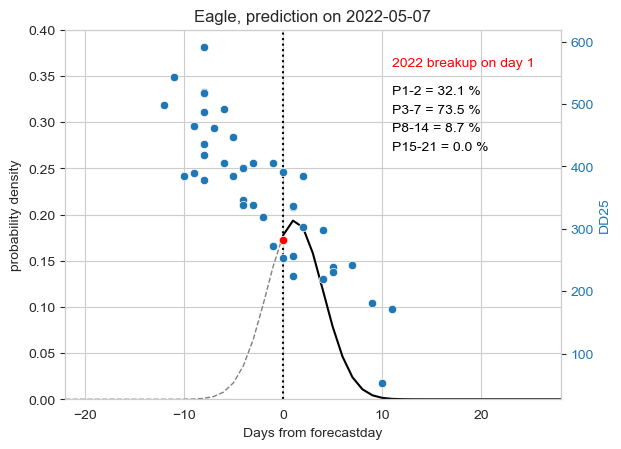

-0.4085029883187481 2.8964741548922857 -2 0.5291236177529469 0.6946366817837262 0.03935153161279159 7.3294969555927e-06


/var/folders/jh/dmrl1jcn7ql6ftcyq7l6p8v80000gn/T/ipykernel_77263/3534468163.py:40: MatplotlibDeprecationWarning: The 'b' parameter of grid() has been renamed 'visible' since Matplotlib 3.5; support for the old name will be dropped two minor releases later.
  ax2.grid(b=None)


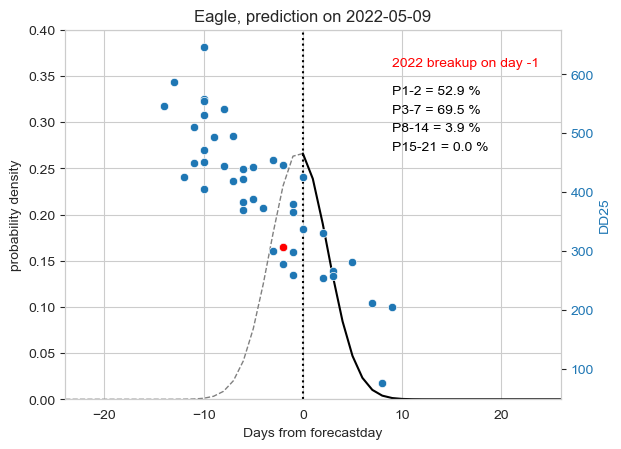

In [ ]:
xs = np.arange(-101, 101)
year = 2022

for ii in range (55, 70, 2):
    breakup_avg_model = linear_model.LinearRegression() 
    DF = likelihoodDF[likelihoodDF.forecast_day_past_march1==ii].copy()
    DDval = DF[DF['year']==str(year)]['mean_DD'].squeeze()
    breakup_avg_model.fit(DF[['mean_DD']].values, DF[['days_from_then']].values)
    mu_0 = breakup_avg_model.predict([[DDval]]).item()
    sigma_0 = mean_squared_error([breakup_avg_model.predict([[dd]]).item() for dd in DF['mean_DD'].tolist()],
                   DF['days_from_then'].tolist(), squared=False)

    # normalize on > 0 values
    pdf = stats.norm.pdf(xs, mu_0, sigma_0)/stats.norm.pdf(xs[101:], mu_0, sigma_0).sum()
    prob_12 = pdf[100:102].sum()
    prob_37 = pdf[102:107].sum()
    prob_wk2 = pdf[107:114].sum()
    prob_wk3 = pdf[114:121].sum()
    breakup_2022 = DF[DF.year==str(year)]['days_from_then'].squeeze()
    forecastdate = ru.dayssince2date(ii, year)
    print(mu_0, sigma_0, breakup_2022, prob_12, prob_37, prob_wk2, prob_wk3)
    fig, ax1 = plt.subplots()
    ax1.plot(xs[:102], pdf[:102], linestyle='dashed', color='grey', linewidth=1)
    ax1.plot(xs[101:], pdf[101:], color='black')
    ax1.vlines(0, 0, 0.4, colors='black', linestyles='dotted')
    ax1.text(78-ii, .36, f"{year} breakup on day {breakup_2022+1}", color='red')
    ax1.text(78-ii, .33, f"P1-2 = {prob_12*100:.1f} %", color='black')
    ax1.text(78-ii, .31, f"P3-7 = {prob_37*100:.1f} %", color='black')
    ax1.text(78-ii, .29, f"P8-14 = {prob_wk2*100:.1f} %", color='black')
    ax1.text(78-ii, .27, f"P15-21 = {prob_wk3*100:.1f} %", color='black')
    ax1.set_ylim((0, 0.40))
    ax1.set_ylabel('probability density')
    ax1.set_xlabel("Days from forecastday")
    ax2 = ax1.twinx()
    color = 'tab:blue'
    sns.scatterplot(data=DF, x='days_from_then', y='mean_DD', ax=ax2)
    sns.scatterplot(data=DF[DF.year=='2022'], x='days_from_then', y='mean_DD', ax=ax2, color='red')
    ax2.set_ylabel('DD25', color=color)
    ax2.tick_params(axis='y', labelcolor=color)
    ax2.grid(b=None)
    plt.title(f"Eagle, prediction on {forecastdate}")
    plt.xlim((45-ii, 95-ii))

    plt.show()
    fig.savefig(outfolder / f"Eagle_DD25_{year}_{forecastdate}.png", bbox_inches='tight')

In [ ]:
stats.norm.pdf(xs, mu_0, sigma_0).sum()

0.41550719987373425

5.78129607869729


/Users/chris/mambaforge/envs/fiweps/lib/python3.10/site-packages/sklearn/base.py:409: UserWarning: X does not have valid feature names, but LinearRegression was fitted with feature names
  warnings.warn(
/Users/chris/mambaforge/envs/fiweps/lib/python3.10/site-packages/sklearn/base.py:409: UserWarning: X does not have valid feature names, but LinearRegression was fitted with feature names
  warnings.warn(
/Users/chris/mambaforge/envs/fiweps/lib/python3.10/site-packages/sklearn/base.py:409: UserWarning: X does not have valid feature names, but LinearRegression was fitted with feature names
  warnings.warn(
/Users/chris/mambaforge/envs/fiweps/lib/python3.10/site-packages/sklearn/base.py:409: UserWarning: X does not have valid feature names, but LinearRegression was fitted with feature names
  warnings.warn(
/Users/chris/mambaforge/envs/fiweps/lib/python3.10/site-packages/sklearn/base.py:409: UserWarning: X does not have valid feature names, but LinearRegression was fitted with feature nam

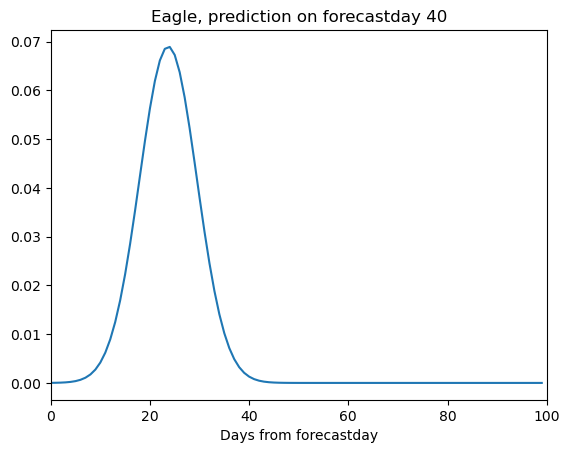

5.78129607869729


/Users/chris/mambaforge/envs/fiweps/lib/python3.10/site-packages/sklearn/base.py:409: UserWarning: X does not have valid feature names, but LinearRegression was fitted with feature names
  warnings.warn(
/Users/chris/mambaforge/envs/fiweps/lib/python3.10/site-packages/sklearn/base.py:409: UserWarning: X does not have valid feature names, but LinearRegression was fitted with feature names
  warnings.warn(
/Users/chris/mambaforge/envs/fiweps/lib/python3.10/site-packages/sklearn/base.py:409: UserWarning: X does not have valid feature names, but LinearRegression was fitted with feature names
  warnings.warn(
/Users/chris/mambaforge/envs/fiweps/lib/python3.10/site-packages/sklearn/base.py:409: UserWarning: X does not have valid feature names, but LinearRegression was fitted with feature names
  warnings.warn(
/Users/chris/mambaforge/envs/fiweps/lib/python3.10/site-packages/sklearn/base.py:409: UserWarning: X does not have valid feature names, but LinearRegression was fitted with feature nam

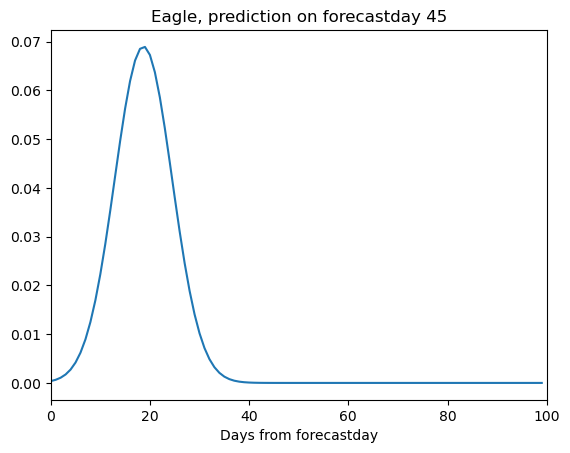

/Users/chris/mambaforge/envs/fiweps/lib/python3.10/site-packages/sklearn/base.py:409: UserWarning: X does not have valid feature names, but LinearRegression was fitted with feature names
  warnings.warn(
/Users/chris/mambaforge/envs/fiweps/lib/python3.10/site-packages/sklearn/base.py:409: UserWarning: X does not have valid feature names, but LinearRegression was fitted with feature names
  warnings.warn(
/Users/chris/mambaforge/envs/fiweps/lib/python3.10/site-packages/sklearn/base.py:409: UserWarning: X does not have valid feature names, but LinearRegression was fitted with feature names
  warnings.warn(
/Users/chris/mambaforge/envs/fiweps/lib/python3.10/site-packages/sklearn/base.py:409: UserWarning: X does not have valid feature names, but LinearRegression was fitted with feature names
  warnings.warn(
/Users/chris/mambaforge/envs/fiweps/lib/python3.10/site-packages/sklearn/base.py:409: UserWarning: X does not have valid feature names, but LinearRegression was fitted with feature nam

5.78129607869729


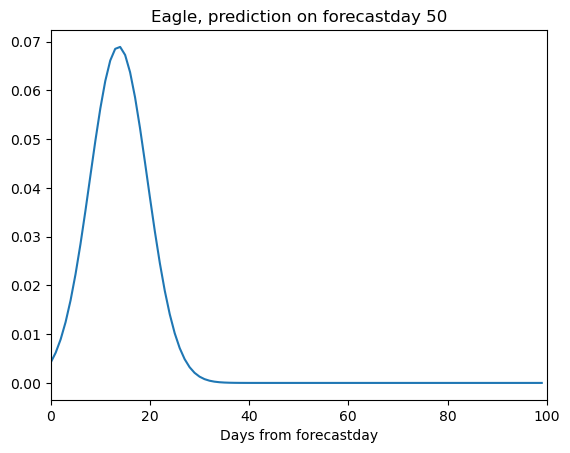

/Users/chris/mambaforge/envs/fiweps/lib/python3.10/site-packages/sklearn/base.py:409: UserWarning: X does not have valid feature names, but LinearRegression was fitted with feature names
  warnings.warn(
/Users/chris/mambaforge/envs/fiweps/lib/python3.10/site-packages/sklearn/base.py:409: UserWarning: X does not have valid feature names, but LinearRegression was fitted with feature names
  warnings.warn(
/Users/chris/mambaforge/envs/fiweps/lib/python3.10/site-packages/sklearn/base.py:409: UserWarning: X does not have valid feature names, but LinearRegression was fitted with feature names
  warnings.warn(
/Users/chris/mambaforge/envs/fiweps/lib/python3.10/site-packages/sklearn/base.py:409: UserWarning: X does not have valid feature names, but LinearRegression was fitted with feature names
  warnings.warn(
/Users/chris/mambaforge/envs/fiweps/lib/python3.10/site-packages/sklearn/base.py:409: UserWarning: X does not have valid feature names, but LinearRegression was fitted with feature nam

5.78129607869729


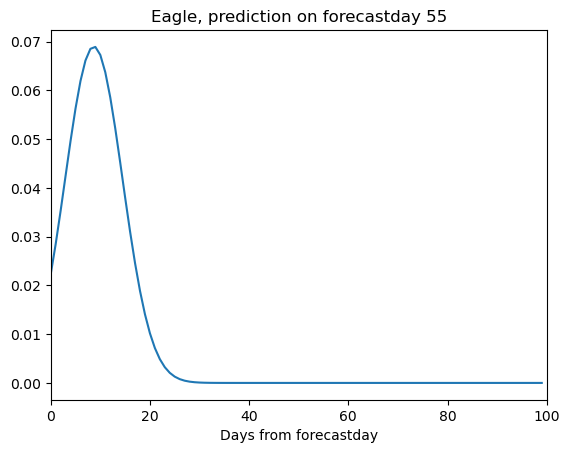

/Users/chris/mambaforge/envs/fiweps/lib/python3.10/site-packages/sklearn/base.py:409: UserWarning: X does not have valid feature names, but LinearRegression was fitted with feature names
  warnings.warn(
/Users/chris/mambaforge/envs/fiweps/lib/python3.10/site-packages/sklearn/base.py:409: UserWarning: X does not have valid feature names, but LinearRegression was fitted with feature names
  warnings.warn(
/Users/chris/mambaforge/envs/fiweps/lib/python3.10/site-packages/sklearn/base.py:409: UserWarning: X does not have valid feature names, but LinearRegression was fitted with feature names
  warnings.warn(
/Users/chris/mambaforge/envs/fiweps/lib/python3.10/site-packages/sklearn/base.py:409: UserWarning: X does not have valid feature names, but LinearRegression was fitted with feature names
  warnings.warn(
/Users/chris/mambaforge/envs/fiweps/lib/python3.10/site-packages/sklearn/base.py:409: UserWarning: X does not have valid feature names, but LinearRegression was fitted with feature nam

5.78129607869729


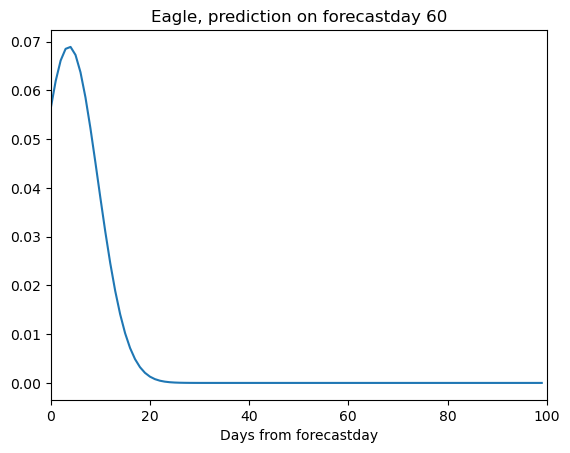

In [ ]:
for ii in range (40, 65, 5):
    breakup_avg_model = linear_model.LinearRegression() 
    DF = likelihoodDF[likelihoodDF.forecast_day_past_march1==ii].copy()
    breakup_avg_model.fit(DF[['year']], DF[['days_from_then']])
    mu_0 = breakup_avg_model.predict([[2023]]).item()
    sigma_0 = mean_squared_error([breakup_avg_model.predict([[yr]]).item() for yr in DF['year'].astype(int).tolist()],
                   DF['days_from_then'].tolist(), squared=False)
    print(sigma_0)
    plt.plot(xs, stats.norm.pdf(xs, mu_0, sigma_0))
    plt.title(f"Eagle, prediction on forecastday {ii}")
    plt.xlabel("Days from forecastday")
    plt.xlim((0, 100))
    plt.show()

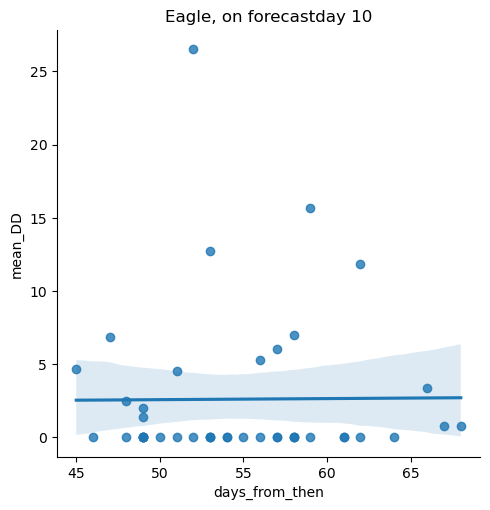

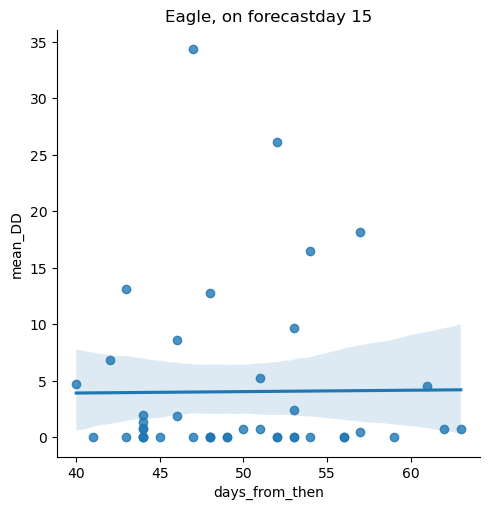

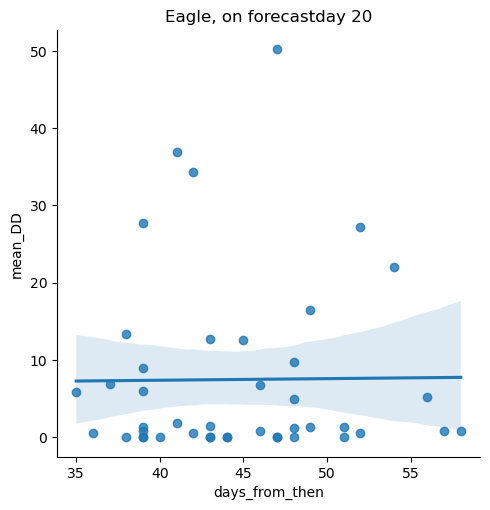

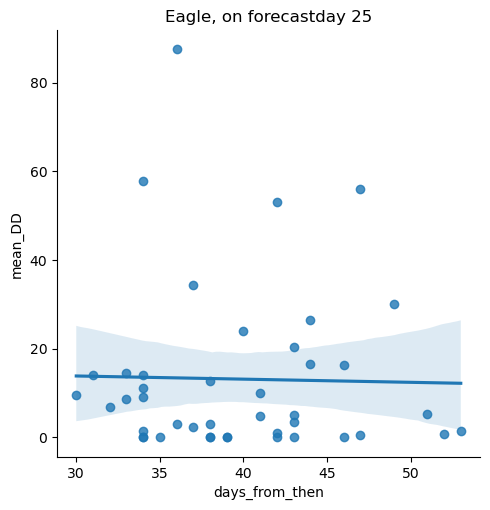

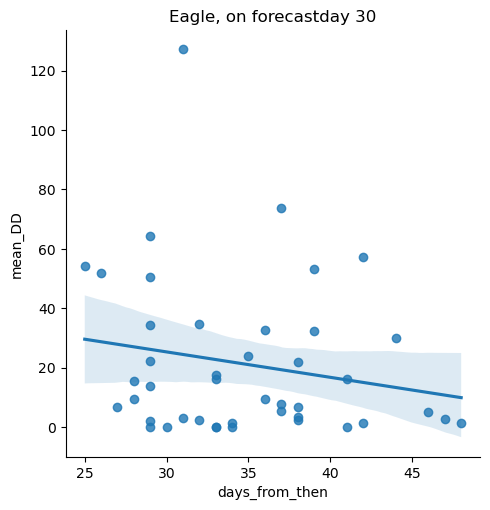

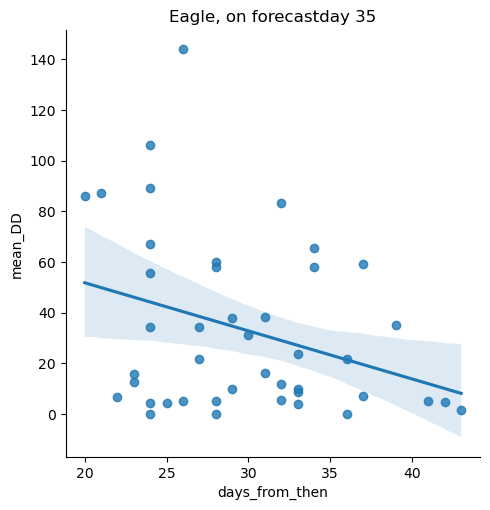

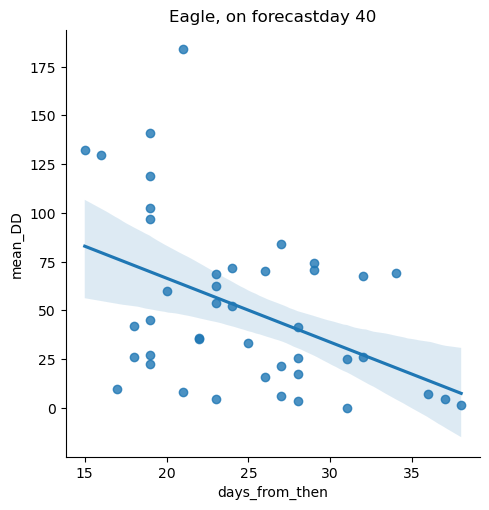

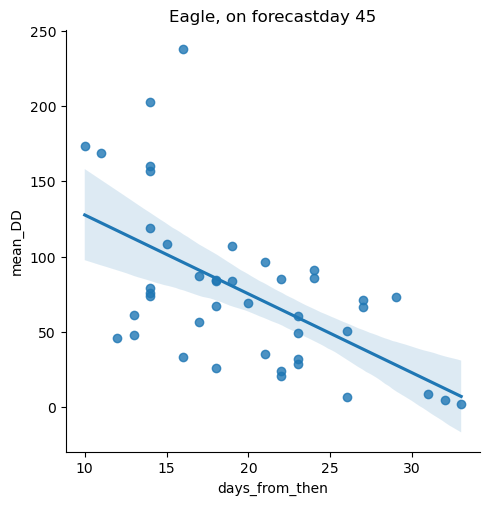

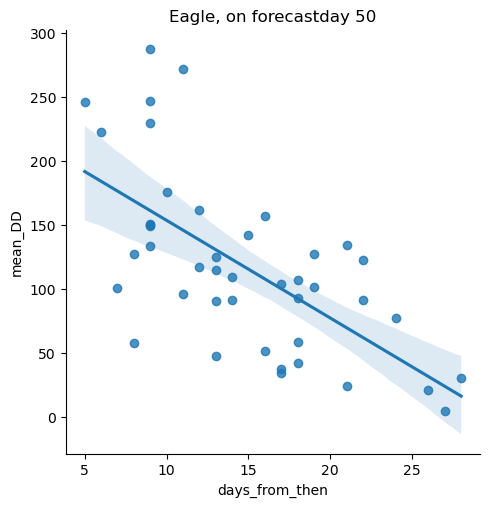

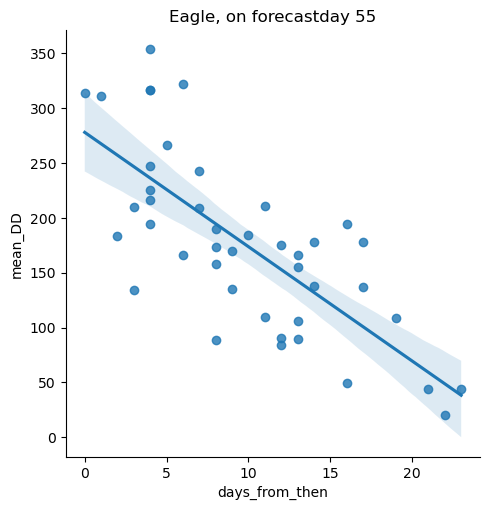

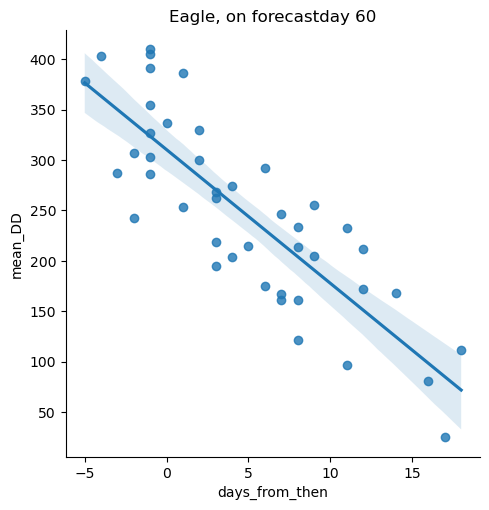

In [ ]:
# pivoted = likelihoodDF.pivot(index='forecast_day_past_march1', columns='days_from_then', values='mean_DD')
for ii in range (10, 65, 5):
    sns.lmplot(data=likelihoodDF[likelihoodDF.forecast_day_past_march1==ii], x='days_from_then', y='mean_DD')
    plt.title(f"Eagle, on forecastday {ii}")

Text(41.31482827771349, 0.5, 'Breakup in ... days')

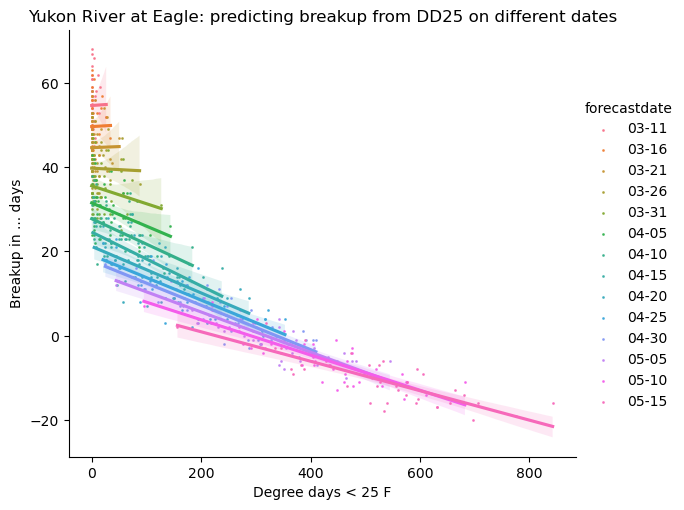

In [ ]:
sns.lmplot(data=likelihoodDF[likelihoodDF.forecast_day_past_march1 % 5 == 0], 
           hue='forecastdate', y='days_from_then', x='mean_DD', 
           scatter=True, scatter_kws={"s": 1},
           aspect=1.2,
           )
plt.title(f"Yukon River at Eagle: predicting breakup from {prefix} on different dates")
plt.xlabel('Degree days < 25 F')
plt.ylabel("Breakup in ... days")

In [ ]:
possible_days = sorted(list(set(breakup['days_since_march1'])))
records = []

for days in possible_days:
    days_possible = days + days_after_march_1
    years = breakup[breakup['days_since_march1']==days].year.astype(str).to_list()
    if years != []:
        records.append(
            {'days_after_march_1': days_after_march_1,
                'days_from_then': days,
                'mean_DD': mean_eagle[years].mean(axis=1)[days_after_march_1]}
        )

In [ ]:
mean_eagle[['2014', '2019']].mean(axis=1)[0]

0.0

<AxesSubplot: xlabel='d_since_march1'>

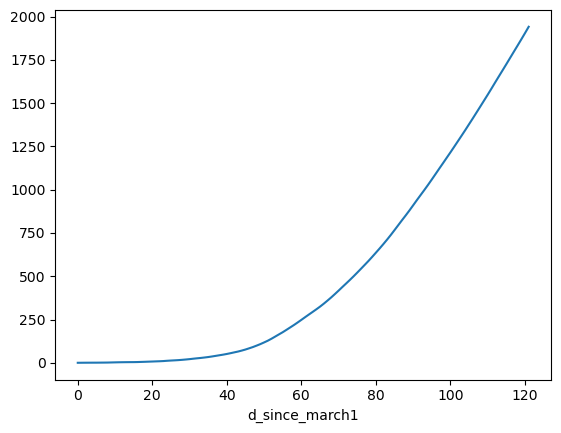

In [ ]:
mean_eagle.mean(axis=1).plot()

<AxesSubplot: xlabel='d_since_march1'>

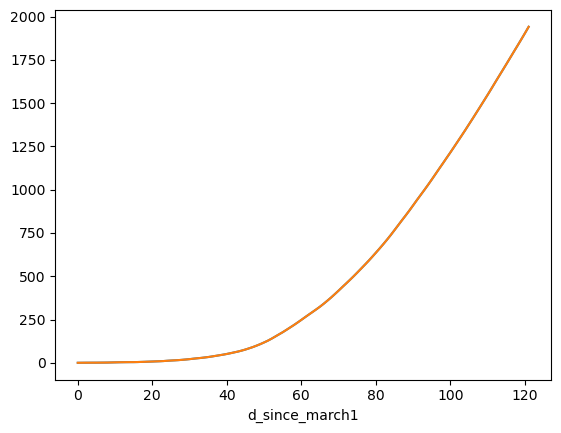

In [ ]:
mean_eagle1 = pd.concat(stationsdfs.values())
mean_eagle1 = mean_eagle1.groupby(mean_eagle1.index).mean()
ax = mean_eagle1.mean(axis=1).plot()
mean_eagle.mean(axis=1).plot(ax=ax)

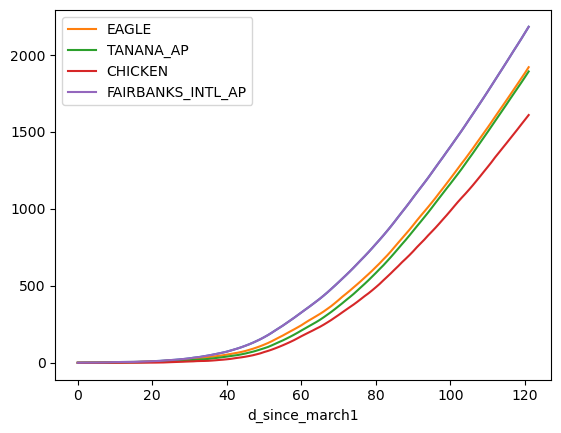

In [ ]:
ax = stationsdfs['FAIRBANKS_INTL_AP'].mean(axis=1).plot()
for key in stationsdfs.keys():
    stationsdfs[key].mean(axis=1).plot(ax=ax, label=key)
plt.legend()

## Make a combined dataset for stationdata

In [ ]:
sites = ['FAIRBANKS_INTL_AP', 'EAGLE', 'BIG_DELTA_AIRPORT', 'NENANA_MUN_AP']

In [ ]:
stationsdfs = {}
stationfolder = Path("/Users/christine/Projects/2023_Riverice/data/weatherstations/ACIS/TDD/tdd_cumul_bystation")
for station in sites2:
    stationsdfs[station] = pd.read_csv(stationfolder / f"{station}_yearly_TDD_cumul.csv", skiprows=4, index_col=0)